# SOI1010 Machine Learning II - Assignment #2

The submission should include a code (both link to the colab and .py format) and a report that has answers to the questions and results. Use PyTorch (or TensorFlow/JAX). Also, minimize the use of numpy. There will be mark deductions if numpy is used when PyTorch is preferable or should be used. Marks will be deducted if the submission does not include the requested files. DO NOT use other libraries, such as scikit-learn/sklearn, to use a model (kNN in this case) you are supposed to implement. Using sklearn or any other third library or already built-in functions that you are asked to implement will result in 0 mark. So, please don’t ask “Can I use this library/numpy/etc.?” Also, if an assignment asks you to implement some model, that means you shouldn’t use the built-in implementation from any library for that model in the first place.

### Problem #2 [Bonus/Optional]: Multiclass Classification via soft-margin SVM on CIFAR10

##### a) Perform multiclass classification using soft-margin SVM on the whole dataset.

In [113]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Now using {device}")

Now using mps


In [114]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                            transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                            transform=transform)

traindata, validdata = random_split(trainset, [int(len(trainset)*.9), int(len(trainset)*.1)])
train_loader = DataLoader(traindata, batch_size=64, shuffle=True)
valid_loader = DataLoader(validdata, batch_size=64, shuffle=True)
print(f'''Train Data : {len(traindata)}
Valid Data : {len(validdata)}
''')

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Train Data : 45000
Valid Data : 5000

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]), torch.int64


In [116]:
labels_map = {j:i for (i,j) in trainset.class_to_idx.items()}
labels_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [120]:
#### Hyperparameters ####
bs = 64
epochs = 10
learning_rate = 0.001
gamma = 1

In [121]:
class SVM(nn.Module):
    def __init__(self, gamma=1.0):
        super(SVM, self).__init__()
        self.func = nn.Linear(3072, 10)
        self.gamma = gamma

    def forward(self, x):
        x = x.view(x.size(0), -1)
        fwd = self.func(x)
        return fwd

model = SVM(gamma).to(device)
print(model)

SVM(
  (func): Linear(in_features=3072, out_features=10, bias=True)
)


In [122]:
# Train
def train(dataloader, model, loss_fn, optimizer, epochs):
    hist = []
    for epoch in range(epochs):
        print(f"-------Epoch {epoch+1:2}-------")
        loss_ = 0
        for x, y in tqdm(dataloader, total=len(dataloader)):
            x, y = Variable(x).to(device), Variable(y).to(device)
            
            optimizer.zero_grad()

            yhat = model(x).softmax(dim=1) 
            loss = loss_fn(yhat, y) + torch.norm(model.func.weight) / (2 * model.gamma)
            
            loss.backward()
            optimizer.step()

            loss_ += loss.item()
            
        loss_ /= len(dataloader)
            
        print(f'Average Loss: {loss_}\n')
        hist.append(loss_)
    return hist

In [123]:
# Loss function
def CrossEntropy(yhat, y):
    oh_lbl = torch.nn.functional.one_hot(y, num_classes=yhat.size(1))
    loss = -torch.sum(oh_lbl * torch.log(yhat), dim=1).mean()
    return loss

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

-------Epoch  1-------


100%|██████████| 704/704 [00:06<00:00, 110.08it/s]


Average Loss: 2.2877924885939467

-------Epoch  2-------


100%|██████████| 704/704 [00:05<00:00, 118.26it/s]


Average Loss: 2.2391686530953105

-------Epoch  3-------


100%|██████████| 704/704 [00:06<00:00, 113.95it/s]


Average Loss: 2.23707954314622

-------Epoch  4-------


100%|██████████| 704/704 [00:05<00:00, 120.37it/s]


Average Loss: 2.2364713217724455

-------Epoch  5-------


100%|██████████| 704/704 [00:05<00:00, 117.95it/s]


Average Loss: 2.242997679012743

-------Epoch  6-------


100%|██████████| 704/704 [00:06<00:00, 114.78it/s]


Average Loss: 2.2345795475623826

-------Epoch  7-------


100%|██████████| 704/704 [00:06<00:00, 109.70it/s]


Average Loss: 2.2374933561818167

-------Epoch  8-------


100%|██████████| 704/704 [00:06<00:00, 104.45it/s]


Average Loss: 2.2396002555774017

-------Epoch  9-------


100%|██████████| 704/704 [00:07<00:00, 98.94it/s] 


Average Loss: 2.2441141231154855

-------Epoch 10-------


100%|██████████| 704/704 [00:06<00:00, 104.33it/s]


Average Loss: 2.2423190808093008



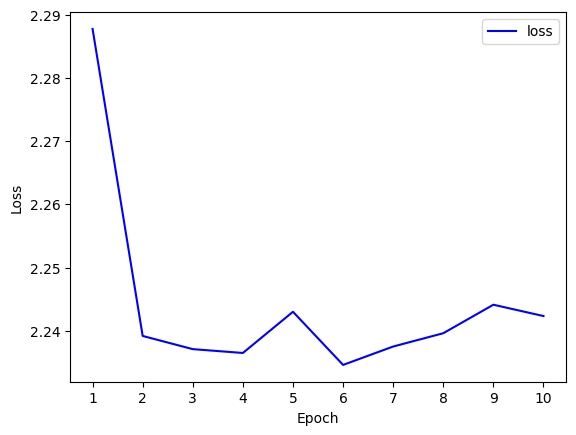

In [124]:
# Train Model
model.train()
hist = train(train_loader, model, CrossEntropy, optimizer, epochs)
plt.plot(range(1, epochs+1), hist, 'b', label='loss')
plt.xticks(range(1, epochs+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig9_multi_loss.png', dpi=200)

In [125]:
classes = list(labels_map.values())
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).softmax(dim=1)
        _, predictions = torch.max(outputs, dim=1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                correct += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:10s} is {accuracy:.2f}% ({correct_count:3}/{total_pred[classname]})')

print()
print(f"Total Accuracy : {100 * correct / len(validdata):.2f}% ({correct}/{len(validdata)})")

Accuracy for class: airplane   is 33.27% (164/493)
Accuracy for class: automobile is 40.43% (205/507)
Accuracy for class: bird       is 14.75% ( 73/495)
Accuracy for class: cat        is 8.02% ( 39/486)
Accuracy for class: deer       is 38.62% (202/523)
Accuracy for class: dog        is 34.48% (170/493)
Accuracy for class: frog       is 12.40% ( 65/524)
Accuracy for class: horse      is 23.88% (107/448)
Accuracy for class: ship       is 69.92% (358/512)
Accuracy for class: truck      is 18.69% ( 97/519)

Total Accuracy : 29.60% (1480/5000)


In [126]:
def predict(data, model):
    with torch.no_grad():
        model.eval()
        data = data.view(1, -1).to(device)
        yhat = model(data)
        val, ind = torch.max(yhat, dim=1)
        return ind

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


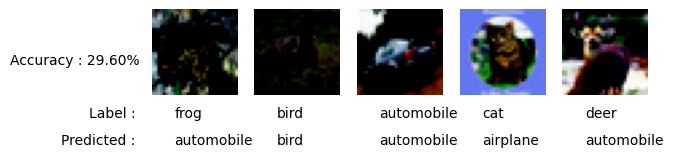

In [128]:
# Predict several data
pick_data = np.random.choice(len(valid_loader), 5, replace=False)
for i in range(5):
    plt.subplot(1,5,i+1)
    
    if i == 0:
        plt.text(-5, 40, "Label : ", horizontalalignment='right')
        plt.text(-5, 50, "Predicted : ", horizontalalignment='right')
        plt.text(-5, 20, f"Accuracy : {100 * correct / len(validdata):.2f}%", horizontalalignment='right')

    data = validdata[pick_data[i]]
    img = data[0]
    label = data[1]
    pred = predict(img, model).item()
    
    plt.imshow(img.permute(1,2,0))
    plt.text(8,40,labels_map[label])
    plt.text(8,50,labels_map[pred])
    plt.axis('off')

plt.savefig('plot/fig10_multi_predict.png', dpi=200, bbox_inches='tight')

##### b) Perform hyperparameter search.

In [80]:
classes = list(labels_map.values())

def evaluation(model, val_dataloader):
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).softmax(dim=1)
            loss = CrossEntropy(outputs, labels) + torch.norm(model.func.weight) / (2 * model.gamma)

            total_loss += loss.item()
            _, predictions = torch.max(outputs, dim=1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct += 1

    final_acc = correct / len(val_dataloader.dataset)
    final_loss = total_loss / len(val_dataloader)
    return final_acc, final_loss

In [83]:
# Grid Search for optimal hyperparameters
def gridSearch(lr_, gamma_, epoch_):
    lst = []
    for gamma__ in gamma_:
        for lr__ in lr_:
            for epoch__ in epoch_:
                model = SVM(gamma__).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr__)
                
                model.train()
                train(train_loader, model, CrossEntropy, optimizer, epoch__)
                acc, los = evaluation(model, valid_loader)
                lst.append([lr__, gamma__, epoch__, acc, los])
    return lst
                

In [ ]:
lr_list = [0.0001, 0.001, 0.01, 0.1]
gamma_list = [0.1, 1.0, 10, 20]
epoch_list = [5, 10, 20, 50, 100]

grid = gridSearch(lr_list, gamma_list, epoch_list)

max_accuracy = max(grid, key=lambda x: x[3])
min_loss = min(grid, key=lambda x: x[4])

In [86]:
max_accuracy

[0.0001, 20, 100, 0.41, 1.7979849712758125]

In [87]:
min_loss

[0.0001, 20, 100, 0.41, 1.7979849712758125]

In [99]:
grid_np = np.array(grid, dtype=np.float64)
np.set_printoptions(precision=6, suppress=True)
grid_np[np.where(grid_np[:,3]>0.4)]


array([[  0.0001  ,  10.      ,  10.      ,   0.4016  ,   1.837483],
       [  0.0001  ,  10.      ,  20.      ,   0.4036  ,   1.833817],
       [  0.0001  ,  10.      ,  50.      ,   0.409   ,   1.834993],
       [  0.0001  ,  20.      ,  10.      ,   0.4026  ,   1.801319],
       [  0.0001  ,  20.      ,  20.      ,   0.4044  ,   1.800351],
       [  0.0001  ,  20.      ,  50.      ,   0.4034  ,   1.798294],
       [  0.0001  ,  20.      , 100.      ,   0.41    ,   1.797985]])

##### c) What is the final __test__  accuracy?  

In [129]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

lr_final = 0.0001
gamma_final = 20
epoch_final = 100

model = SVM(gamma_final).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_final)

model.train()

hist_final = train(train_loader, model, CrossEntropy, optimizer, epoch_final)
plt.plot(range(1, epoch_final+1), hist_final, 'dodgerblue', label='loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig11_multi_test_loss.png', dpi=200, bbox_inches='tight')


-------Epoch  1-------


100%|██████████| 782/782 [00:06<00:00, 112.74it/s]


Average Loss: 1.9197644556269926

-------Epoch  2-------


100%|██████████| 782/782 [00:06<00:00, 121.46it/s]


Average Loss: 1.8290027793106216

-------Epoch  3-------


100%|██████████| 782/782 [00:06<00:00, 118.19it/s]


Average Loss: 1.804807251981457

-------Epoch  4-------


100%|██████████| 782/782 [00:06<00:00, 119.70it/s]


Average Loss: 1.7887915131990866

-------Epoch  5-------


100%|██████████| 782/782 [00:06<00:00, 113.42it/s]


Average Loss: 1.7789689038720582

-------Epoch  6-------


100%|██████████| 782/782 [00:06<00:00, 111.75it/s]


Average Loss: 1.770496781829678

-------Epoch  7-------


100%|██████████| 782/782 [00:07<00:00, 111.22it/s]


Average Loss: 1.7640415428544554

-------Epoch  8-------


100%|██████████| 782/782 [00:06<00:00, 115.70it/s]


Average Loss: 1.7605449784442286

-------Epoch  9-------


100%|██████████| 782/782 [00:07<00:00, 110.65it/s]


Average Loss: 1.756279554970734

-------Epoch 10-------


100%|██████████| 782/782 [00:07<00:00, 105.36it/s]


Average Loss: 1.7526750416706895

-------Epoch 11-------


100%|██████████| 782/782 [00:07<00:00, 110.43it/s]


Average Loss: 1.7500600474874686

-------Epoch 12-------


100%|██████████| 782/782 [00:07<00:00, 105.72it/s]


Average Loss: 1.7483514088498966

-------Epoch 13-------


100%|██████████| 782/782 [00:07<00:00, 109.82it/s]


Average Loss: 1.7456321437340563

-------Epoch 14-------


100%|██████████| 782/782 [00:07<00:00, 110.24it/s]


Average Loss: 1.7443681699235727

-------Epoch 15-------


100%|██████████| 782/782 [00:07<00:00, 100.37it/s]


Average Loss: 1.7420675179842489

-------Epoch 16-------


100%|██████████| 782/782 [00:07<00:00, 105.42it/s]


Average Loss: 1.7408688191867545

-------Epoch 17-------


100%|██████████| 782/782 [00:06<00:00, 112.04it/s]


Average Loss: 1.7403833715202253

-------Epoch 18-------


100%|██████████| 782/782 [00:07<00:00, 103.38it/s]


Average Loss: 1.738535783632332

-------Epoch 19-------


100%|██████████| 782/782 [00:07<00:00, 104.99it/s]


Average Loss: 1.7377035142210744

-------Epoch 20-------


100%|██████████| 782/782 [00:07<00:00, 106.38it/s]


Average Loss: 1.736876084371601

-------Epoch 21-------


100%|██████████| 782/782 [00:07<00:00, 110.29it/s]


Average Loss: 1.7360754035927755

-------Epoch 22-------


100%|██████████| 782/782 [00:07<00:00, 109.81it/s]


Average Loss: 1.7356594741496894

-------Epoch 23-------


100%|██████████| 782/782 [00:06<00:00, 115.54it/s]


Average Loss: 1.735795524876441

-------Epoch 24-------


100%|██████████| 782/782 [00:06<00:00, 117.39it/s]


Average Loss: 1.7359968189083401

-------Epoch 25-------


100%|██████████| 782/782 [00:06<00:00, 117.86it/s]


Average Loss: 1.7338415741005822

-------Epoch 26-------


100%|██████████| 782/782 [00:06<00:00, 112.37it/s]


Average Loss: 1.7342258478369554

-------Epoch 27-------


100%|██████████| 782/782 [00:06<00:00, 113.29it/s]


Average Loss: 1.733284440644257

-------Epoch 28-------


100%|██████████| 782/782 [00:06<00:00, 113.23it/s]


Average Loss: 1.7337621642500542

-------Epoch 29-------


100%|██████████| 782/782 [00:06<00:00, 117.09it/s]


Average Loss: 1.7326901446827843

-------Epoch 30-------


100%|██████████| 782/782 [00:06<00:00, 121.14it/s]


Average Loss: 1.7318882230297683

-------Epoch 31-------


100%|██████████| 782/782 [00:06<00:00, 119.98it/s]


Average Loss: 1.7316813775340614

-------Epoch 32-------


100%|██████████| 782/782 [00:07<00:00, 106.35it/s]


Average Loss: 1.732432603378735

-------Epoch 33-------


100%|██████████| 782/782 [00:06<00:00, 112.81it/s]


Average Loss: 1.7312754159388335

-------Epoch 34-------


100%|██████████| 782/782 [00:06<00:00, 112.23it/s]


Average Loss: 1.7322345522358595

-------Epoch 35-------


100%|██████████| 782/782 [00:07<00:00, 106.26it/s]


Average Loss: 1.7318036290995604

-------Epoch 36-------


100%|██████████| 782/782 [00:07<00:00, 109.27it/s]


Average Loss: 1.7308464864330828

-------Epoch 37-------


100%|██████████| 782/782 [00:06<00:00, 115.16it/s]


Average Loss: 1.7312876423606482

-------Epoch 38-------


100%|██████████| 782/782 [00:06<00:00, 122.41it/s]


Average Loss: 1.7310914441447733

-------Epoch 39-------


100%|██████████| 782/782 [00:07<00:00, 106.87it/s]


Average Loss: 1.7302980708039326

-------Epoch 40-------


100%|██████████| 782/782 [00:06<00:00, 116.74it/s]


Average Loss: 1.7302871477573425

-------Epoch 41-------


100%|██████████| 782/782 [00:06<00:00, 120.86it/s]


Average Loss: 1.7312413280272423

-------Epoch 42-------


100%|██████████| 782/782 [00:07<00:00, 101.75it/s]


Average Loss: 1.731252119059453

-------Epoch 43-------


 26%|██▋       | 206/782 [00:01<00:04, 119.34it/s]

In [111]:
# Performance for each class
classes = list(labels_map.values())
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).softmax(dim=1)
        _, predictions = torch.max(outputs, dim=1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                correct += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:10s} is {accuracy:.2f}% ({correct_count:3}/{total_pred[classname]})')

print()
print(f"Total Accuracy : {100 * correct / len(testset):.2f}% ({correct}/{len(testset)})")

Accuracy for class: airplane   is 49.00% (490/1000)
Accuracy for class: automobile is 48.10% (481/1000)
Accuracy for class: bird       is 26.00% (260/1000)
Accuracy for class: cat        is 27.50% (275/1000)
Accuracy for class: deer       is 33.10% (331/1000)
Accuracy for class: dog        is 33.90% (339/1000)
Accuracy for class: frog       is 49.60% (496/1000)
Accuracy for class: horse      is 45.30% (453/1000)
Accuracy for class: ship       is 52.00% (520/1000)
Accuracy for class: truck      is 49.40% (494/1000)

Total Accuracy : 41.39% (4139/10000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


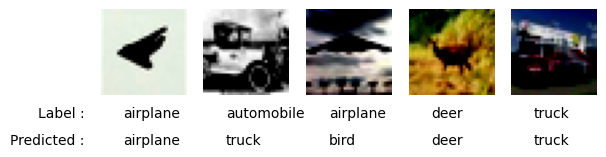

In [112]:
# Predict several data
pick_data = np.random.choice(len(test_loader), 5, replace=False)
for i in range(5):
    plt.subplot(1,5,i+1)
    
    if i == 0:
        plt.text(-5, 40, "Label : ", horizontalalignment='right')
        plt.text(-5, 50, "Predicted : ", horizontalalignment='right')

    data = testset[pick_data[i]]
    img = data[0]
    label = data[1]
    pred = predict(img, model).item()
    
    plt.imshow(img.permute(1,2,0))
    plt.text(8,40,labels_map[label])
    plt.text(8,50,labels_map[pred])
    plt.axis('off')

plt.savefig('plot/fig10_multi_test_predict.png', dpi=200, bbox_inches='tight')